In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import optuna
import tqdm
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from dataplotlib import make_heatmap
from lightgbm import LGBMClassifier

e:\Git Projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = r'E:\Downloads\playground-series-s4e7'

In [3]:
train = pd.read_csv(path + r'\train.csv')

In [4]:
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


In [20]:
train.drop(axis=1, columns='id', inplace=True)

In [21]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Region_Code,11504798.0,26.418690,12.991590,0.0,15.0,28.0,35.0,52.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Annual_Premium,11504798.0,30461.370411,16454.745205,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0
Response,11504798.0,0.122997,0.328434,0.0,0.0,0.0,0.0,1.0


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 965.5+ MB


In [23]:
train.isna().sum()/len(train) * 100

Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
Response                0.0
dtype: float64

In [34]:
cat_cols = train.select_dtypes(['object']).columns.tolist()
num_cols = train.select_dtypes([np.float64, np.int64]).columns.tolist()
print(f'Categorical : {cat_cols}')
print(f'Numerical : {num_cols}')

Categorical : ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
Numerical : ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']


Column plotting : Annual_Premium
Column plotting : Policy_Sales_Channel
Column plotting : Vintage
Column plotting : Age


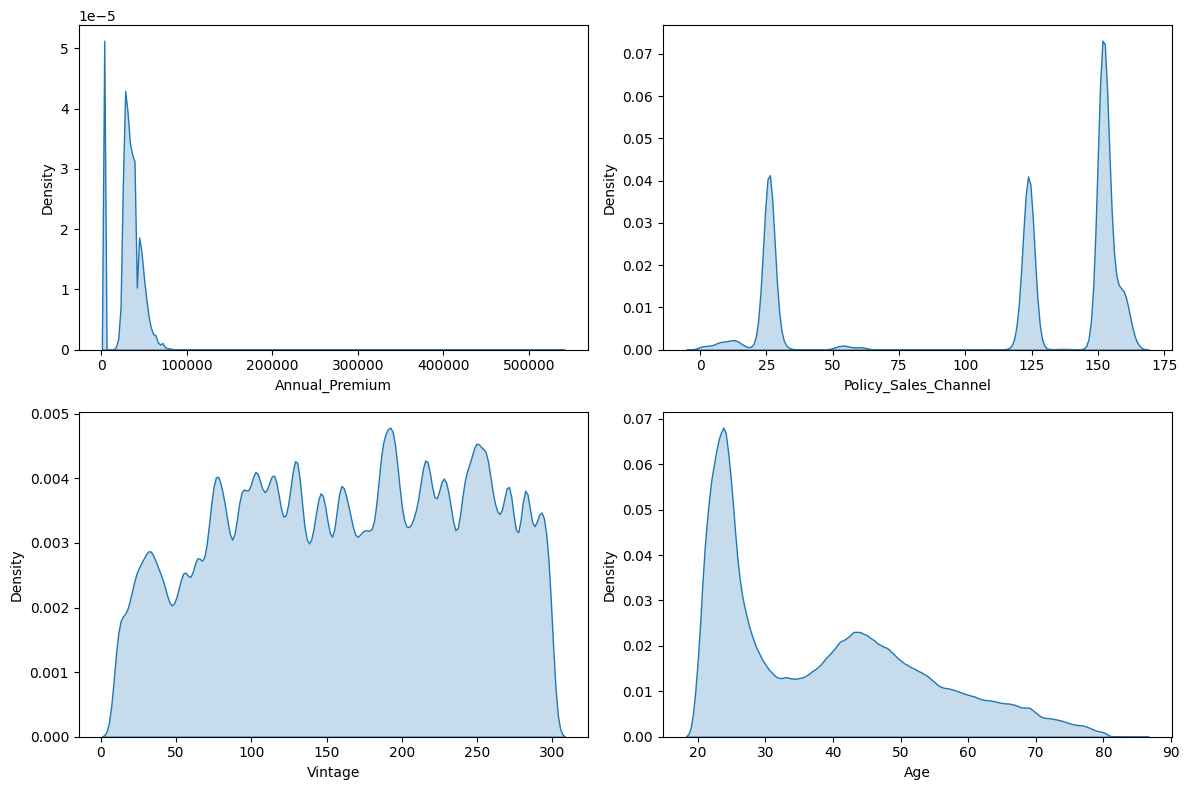

In [27]:
columns_kde = ['Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Age']
n_cols = len(columns_kde)
n_rows = (n_cols + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))


if n_rows > 1:
    axes = axes.flatten()

for i, column in enumerate(columns_kde):
    print(f'Column plotting : {column}')
    sns.kdeplot(train[train[column].notna()][column], fill=True, ax=axes[i])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

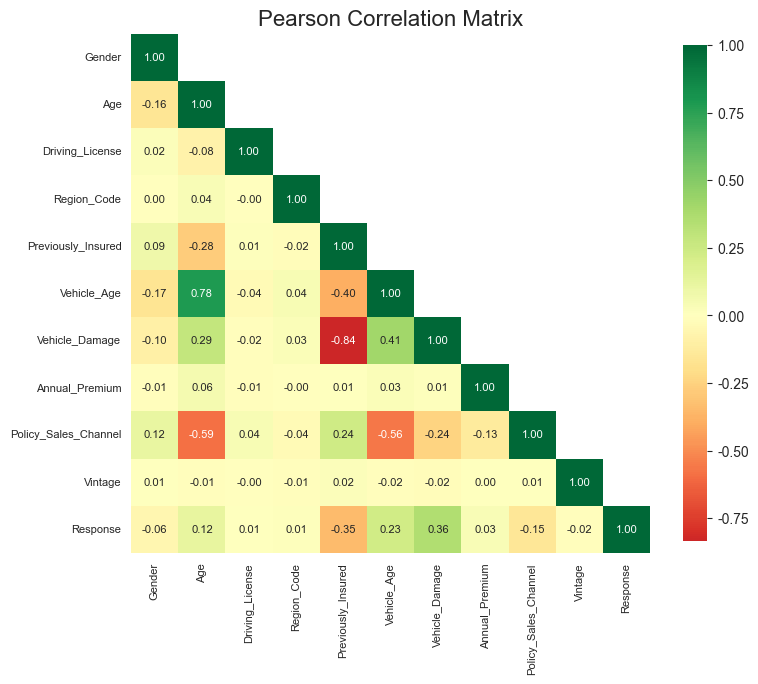

In [40]:
temp = train.copy()
gender_mapping = {'Male': 0, 'Female': 1}
vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
vehicle_damage_mapping = {'No': 0, 'Yes': 1}
temp['Gender'] = temp['Gender'].map(gender_mapping)
temp['Vehicle_Age'] = temp['Vehicle_Age'].map(vehicle_age_mapping)
temp['Vehicle_Damage'] = temp['Vehicle_Damage'].map(vehicle_damage_mapping)
        
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 8))

corr_train = temp.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='RdYlGn',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax 
)

ax.set_title('Pearson Correlation Matrix', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()


### ML

In [28]:
y = train['Response']
X = train.drop(axis=1, columns='Response')

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)

val_pool = Pool(data=X_val, label=y_val, cat_features=cat_cols)

In [ ]:
def objective(trial):
    iterations = trial.suggest_int('iterations', 200, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    depth = trial.suggest_int('depth', 2, 7)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-5, 1e-1, log=True)
    model = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, early_stopping_rounds=50, od_type='IncToDec')
    model.fit(train_pool)
    score = model.eval_metrics(val_pool, metrics='MCC')[0]
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best trial:', study.best_trial.params)
print('Best validation score:', study.best_value)

In [42]:
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    class_names=[0, 1],
    learning_rate=0.075,
    iterations=5000,
    depth=9,
    random_strength=0,
    l2_leaf_reg=0.5,
    max_leaves=512,
    fold_permutation_block=64
)

In [43]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

0:	test: 0.8508489	best: 0.8508489 (0)	total: 4.43s	remaining: 6h 9m 16s
1:	test: 0.8515256	best: 0.8515256 (1)	total: 8.71s	remaining: 6h 2m 53s
2:	test: 0.8521984	best: 0.8521984 (2)	total: 13.3s	remaining: 6h 8m 51s
3:	test: 0.8529232	best: 0.8529232 (3)	total: 17.6s	remaining: 6h 5m 28s
4:	test: 0.8531444	best: 0.8531444 (4)	total: 21.6s	remaining: 5h 58m 49s
5:	test: 0.8548335	best: 0.8548335 (5)	total: 26.4s	remaining: 6h 6m 39s
6:	test: 0.8561087	best: 0.8561087 (6)	total: 30.7s	remaining: 6h 4m 49s
7:	test: 0.8569374	best: 0.8569374 (7)	total: 34.8s	remaining: 6h 1m 32s
8:	test: 0.8574849	best: 0.8574849 (8)	total: 39.5s	remaining: 6h 5m 23s
9:	test: 0.8577455	best: 0.8577455 (9)	total: 44.1s	remaining: 6h 6m 31s
10:	test: 0.8587232	best: 0.8587232 (10)	total: 48.4s	remaining: 6h 5m 40s
11:	test: 0.8587931	best: 0.8587931 (11)	total: 55s	remaining: 6h 20m 52s
12:	test: 0.8590447	best: 0.8590447 (12)	total: 59.2s	remaining: 6h 18m 11s
13:	test: 0.8595628	best: 0.8595628 (13)	tot

KeyboardInterrupt: 

In [ ]:
X_pred = pd.read_csv(path + r'\test.csv')

In [ ]:
subm = model.predict(X_pred)
submission_sample = pd.read_csv(path + r'\sample_submission.csv')
submission_sample['class'] = subm
submission_sample.to_csv(r'C:\Users\h\Desktop\ans1.csv', index=False)